In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import datetime
import os
import pickle
import scipy
import colorcet as cc
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

import skies


In [3]:
run_name = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
base_runs_folder = "./runs/"
output_path = os.path.join(base_runs_folder, run_name)
mesh_parameters_file_name = "western_north_america_mesh_parameters.json"
skies.create_output_folder(base_runs_folder, output_path)
meshes = skies.read_meshes(mesh_parameters_file_name)
skies.print_magnitude_overview(meshes)


output_path='./runs/2022_11_11_20_18_14'
Read: western_north_america_mesh_parameters.json



Warning: The file contains tag data that couldn't be processed.

Read: cascadia.msh
Magnitude overview:
Maximum moment magnitude of entire mesh = 10.61
Maximum moment magnitude of single mesh element = 6.90
Minimum moment magnitude of single mesh element = 5.52


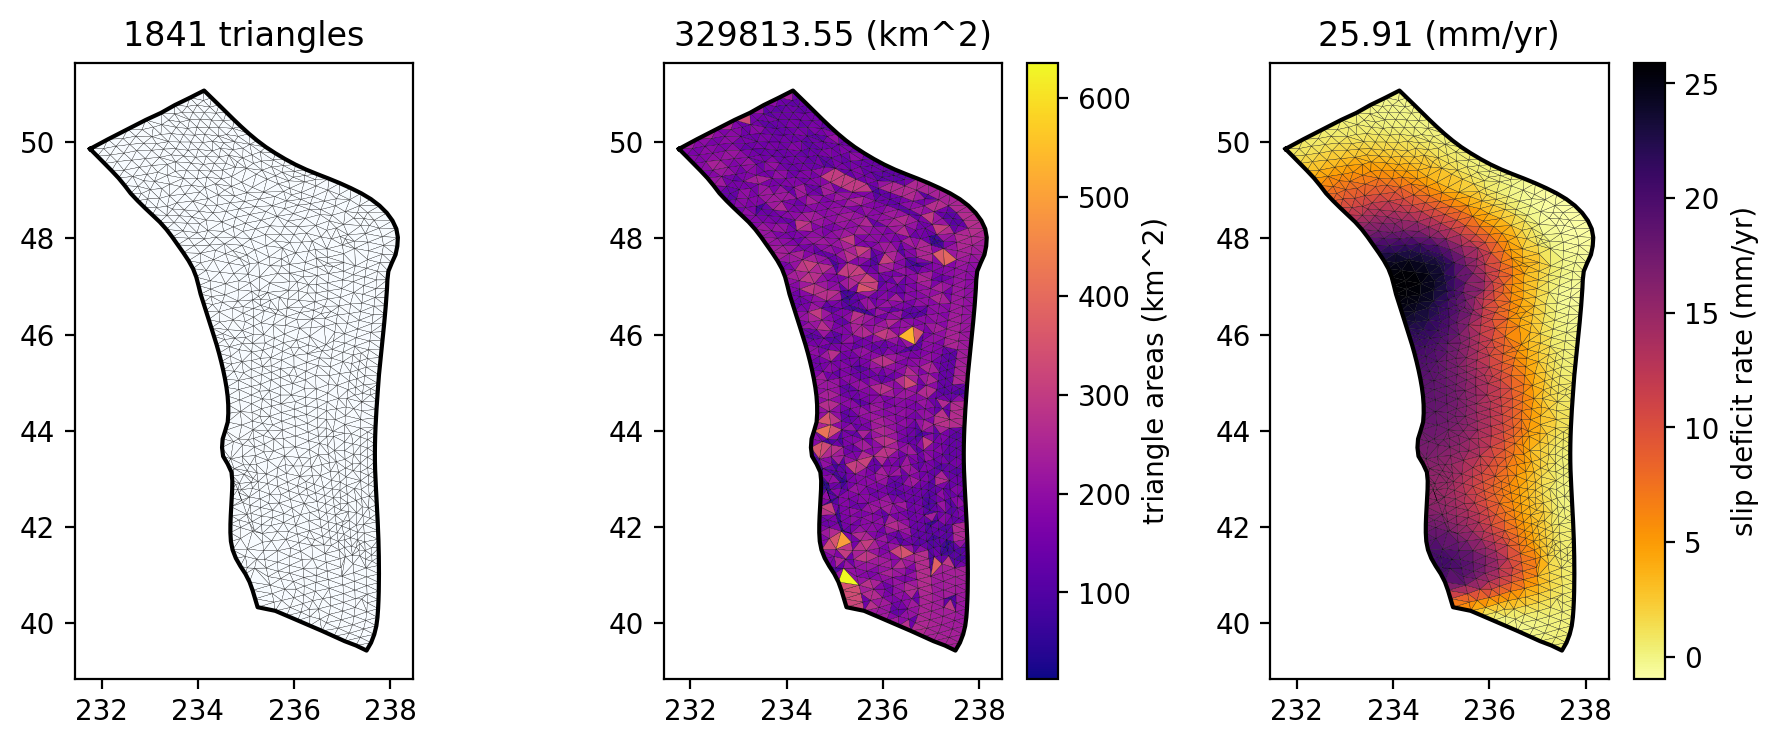

In [4]:
# Load initial slip defict and multiply by time cascadia_low_resolution_tde_dip_slip_rates.npy
mesh_initial_dip_slip_deficit = np.load("cascadia_low_resolution_tde_dip_slip_rates.npy")
skies.plot_initial_data(meshes, mesh_initial_dip_slip_deficit)


In [5]:
import matplotlib
import timeit
from scipy.interpolate import griddata

fontsize = 16
KM2_TO_M2 = 1e6


def plot_event_for_animation(
    event,
    meshes,
    pre_event_slip_deficit,
    probability,
    post_event_slip_deficit,
    last_event_slip,
    total_slip,
    last_event_time,
    t,
    iteration_step,
):
    """
    1. Slip deficit rate
    2. Current moment distribution
    3. Slip at current time step
    4. Last earthquake
    5. Total slip
    """

    plt.figure(figsize=(10, 4))

    # Plot spatially variable temporally constant slip deficit rate
    plt.subplot(1, 4, 1)
    fill_value = mesh_initial_dip_slip_deficit
    x_vec = np.linspace(
        params.min_longitude, params.max_longitude, params.n_grid_longitude
    )
    y_vec = np.linspace(
        params.min_latitude, params.max_latitude, params.n_grid_latitude
    )
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    # centroids_val = fill_value
    fill_value_mat = griddata(
        (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
    )
    # Set values outside of mesh polygon to nan so they don't plot
    inpolygon_vals = skies.inpolygon(
        x_mat, y_mat, meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(
        inpolygon_vals, (params.n_grid_longitude, params.n_grid_latitude)
    )
    fill_value_mat[~inpolygon_vals] = np.nan
    cmap = cc.cm.bmy_r
    levels = np.linspace(0, 30, 11)
    plt.contourf(x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both")
    plt.contour(
        x_mat,
        y_mat,
        fill_value_mat,
        colors="k",
        linestyles="solid",
        linewidths=0.25,
        levels=levels,
        extend="both",
    )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.gca().set_facecolor("gainsboro")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("$v_{sd}$", fontsize=fontsize)


    # Plot spatially variable pre event moment
    plt.subplot(1, 4, 2)
    fill_value = pre_event_slip_deficit
    x_vec = np.linspace(
        params.min_longitude, params.max_longitude, params.n_grid_longitude
    )
    y_vec = np.linspace(
        params.min_latitude, params.max_latitude, params.n_grid_latitude
    )
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    # centroids_val = fill_value
    fill_value_mat = griddata(
        (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
    )
    # Set values outside of mesh polygon to nan so they don't plot
    inpolygon_vals = skies.inpolygon(
        x_mat, y_mat, meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(
        inpolygon_vals, (params.n_grid_longitude, params.n_grid_latitude)
    )
    fill_value_mat[~inpolygon_vals] = np.nan
    cmap = cc.cm.CET_L19
    cmap = cc.cm.coolwarm
    levels = np.linspace(-5e9, 5e9, 11)
    plt.contourf(x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both")
    plt.contour(
        x_mat,
        y_mat,
        fill_value_mat,
        colors="k",
        linestyles="solid",
        linewidths=0.25,
        levels=levels,
    )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.gca().set_facecolor("gainsboro")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("$m$", fontsize=fontsize)



    # # Plot coseismic slip distribution
    # plt.subplot(1, 5, 3)
    # fill_value = np.zeros(meshes[0].n_tde)
    # fill_value[event.triangle_index] = event.slip
    # x_vec = np.linspace(
    #     params.min_longitude, params.max_longitude, params.n_grid_longitude
    # )
    # y_vec = np.linspace(
    #     params.min_latitude, params.max_latitude, params.n_grid_latitude
    # )
    # x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    # centroids_lon = meshes[0].centroids[:, 0]
    # centroids_lat = meshes[0].centroids[:, 1]
    # centroids_val = fill_value
    # fill_value_mat = griddata(
    #     (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
    # )
    # # Set values outside of mesh polygon to nan so they don't plot
    # inpolygon_vals = skies.inpolygon(
    #     x_mat, y_mat, meshes[0].x_perimeter, meshes[0].y_perimeter
    # )
    # inpolygon_vals = np.reshape(
    #     inpolygon_vals, (params.n_grid_longitude, params.n_grid_latitude)
    # )
    # fill_value_mat[~inpolygon_vals] = np.nan
    # cmap = cc.cm.CET_L19
    # levels = np.linspace(0.1, 10, 11)
    # plt.contourf(x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both")
    # plt.contour(
    #     x_mat,
    #     y_mat,
    #     fill_value_mat,
    #     colors="k",
    #     linestyles="solid",
    #     linewidths=0.25,
    #     levels=levels,
    # )
    # plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    # plt.gca().set_aspect("equal", adjustable="box")
    # plt.gca().set_facecolor("gainsboro")
    # plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    # plt.xticks([])
    # plt.yticks([])
    # print(f"{event.moment_magnitude=}")
    # print(f"{event.moment_magnitude != 0.0}")
    # if event.moment_magnitude != 0.0:
    #     plt.xlabel(f"$M_W$={event.moment_magnitude[0]:0.2f}", fontsize=fontsize)




    # Plot most recent coseismic slip distribution
    plt.subplot(1, 4, 3)
    fill_value = np.zeros(meshes[0].n_tde)
    fill_value = last_event_slip
    x_vec = np.linspace(
        params.min_longitude, params.max_longitude, params.n_grid_longitude
    )
    y_vec = np.linspace(
        params.min_latitude, params.max_latitude, params.n_grid_latitude
    )
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    centroids_val = fill_value
    fill_value_mat = griddata(
        (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
    )
    # Set values outside of mesh polygon to nan so they don't plot
    inpolygon_vals = skies.inpolygon(
        x_mat, y_mat, meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(
        inpolygon_vals, (params.n_grid_longitude, params.n_grid_latitude)
    )
    fill_value_mat[~inpolygon_vals] = np.nan
    cmap = cc.cm.CET_L19
    levels = np.linspace(0.1, 15, 11)
    plt.contourf(x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both")
    plt.contour(
        x_mat,
        y_mat,
        fill_value_mat,
        colors="k",
        linestyles="solid",
        linewidths=0.25,
        levels=levels,
    )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.gca().set_facecolor("gainsboro")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"$t=${last_event_time}, $M_W$={event.moment_magnitude[0]:0.1f}", fontsize=fontsize)
    # plt.xlabel(f"$t=${last_event_time}", fontsize=fontsize)



    # Plot total coseismic slip distribution
    plt.subplot(1, 4, 4)
    fill_value = np.zeros(meshes[0].n_tde)
    fill_value = total_slip
    x_vec = np.linspace(
        params.min_longitude, params.max_longitude, params.n_grid_longitude
    )
    y_vec = np.linspace(
        params.min_latitude, params.max_latitude, params.n_grid_latitude
    )
    x_mat, y_mat = np.meshgrid(x_vec, y_vec)
    centroids_lon = meshes[0].centroids[:, 0]
    centroids_lat = meshes[0].centroids[:, 1]
    # centroids_val = fill_value
    fill_value_mat = griddata(
        (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
    )
    # Set values outside of mesh polygon to nan so they don't plot
    inpolygon_vals = skies.inpolygon(
        x_mat, y_mat, meshes[0].x_perimeter, meshes[0].y_perimeter
    )
    inpolygon_vals = np.reshape(
        inpolygon_vals, (params.n_grid_longitude, params.n_grid_latitude)
    )
    fill_value_mat[~inpolygon_vals] = np.nan
    cmap = cc.cm.bmy_r
    levels = np.linspace(0.1, 15, 11)
    plt.contourf(x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both")
    plt.contour(
        x_mat,
        y_mat,
        fill_value_mat,
        colors="k",
        linestyles="solid",
        linewidths=0.25,
        levels=levels,
    )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.gca().set_facecolor("gainsboro")
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("$\sum s$", fontsize=fontsize)

    plt.suptitle(f"$t$={iteration_step}", fontsize=fontsize)

    # Save figure to file
    base_file_name = f"{iteration_step:010d}"
    plt.savefig(base_file_name + ".png", dpi=500)
    plt.close("all")
    # plt.show()


In [6]:
np.random.seed(2)
# Save random state from good run
# https://stackoverflow.com/questions/32808686/storing-a-random-state#:~:text=You%20can%20save%20the%20state,the%20state%20it%20was%20in.


# Parameters for model run
params = addict.Dict()
params.n_time_steps = 40000
params.time_step = 5e-7
params.b_value = -1.0
params.shear_modulus = 3e10
params.n_samples = 1
params.n_binary = 2
params.minimum_event_moment_magnitude = 6.0
params.maximum_event_moment_magnitude = 9.0
params.time_probability_amplitude_scale_factor = 5e-2
params.time_probability_data_scale_factor = 1e-12
params.area_scaling = 1.25
params.default_omori_decay_time = 100.0
params.minimum_probability = 1e-10
params.time_probability_history_scale_factor = 1e11
params.location_probability_amplitude_scale_factor = 1.0
params.location_probability_data_scale_factor = 1e-5
params.omori_amplitude_scale_factor = 3e-9
params.omori_rate_perturbation_scale_factor = 1e-1
params.mesh_index = 0
params.initial_mesh_slip_deficit_scaling = 0.0
params.geometic_moment_rate_scale_factor = 5e1
params.plot_events_in_loop = True
params.n_events_omori_history_effect = 100
params.n_grid_longitude = 500
params.n_grid_latitude = 500
params.min_longitude = 239.0
params.max_longitude = 231.0
params.min_latitude = 38.0
params.max_latitude = 52.0
params.n_contour_levels = 10
params.min_contour_value = 0.1  # (m)

# Select mesh if multiple have been loaded
mesh = meshes[params.mesh_index]

# Storage
time_series = addict.Dict()
time_series.time = np.linspace(0, params.n_time_steps, params.n_time_steps)
time_series.probability_weight = np.zeros_like(time_series.time)
time_series.probability = np.zeros_like(time_series.time)
time_series.event_magnitude = np.zeros_like(time_series.time)
time_series.event_trigger_flag = np.zeros_like(time_series.time)
time_series.last_event_time = 0

# TODO: #22 Change earthquake to event. Make a dictionary?  Can I eliminate `earthquake_index_list`, `earthquake_magnitude_list`, `earthquake_probability_list`
earthquake_probability_list = []
time_series.omori_history_effect = np.zeros(
    (params.n_time_steps, params.n_events_omori_history_effect)
)

# Initial geometric moment and storage
# TODO: #23 Convert to mesh_geometric_moment dictionary?
mesh_geometric_moment = np.zeros(mesh.n_tde)
mesh_last_event_slip = np.zeros(mesh.n_tde)
mesh_total_slip = np.zeros(mesh.n_tde)
mesh_geometric_moment_pre_event = np.copy(mesh_geometric_moment)
mesh_geometric_moment_post_event = np.zeros_like(mesh_geometric_moment)
mesh_geometric_moment_scalar = np.zeros_like(time_series.time)
mesh_geometric_moment_scalar_non_zero = np.zeros_like(time_series.time)
mesh_geometric_moment_scalar[0] = np.sum(mesh_geometric_moment)

mesh_interseismic_loading_rate = (
    params.geometic_moment_rate_scale_factor * mesh_initial_dip_slip_deficit
)

# temp = np.zeros((10, mesh.n_tde)) # Track geometric moment maps

# Main time loop
for i in range(params.n_time_steps - 1):
    print(f"Time step {i} of {params.n_time_steps}")

    # Update mesh_geometric_moment
    mesh_geometric_moment += (
        params.time_step * mesh_interseismic_loading_rate * mesh.areas
    )
    # temp[i, :] = mesh_geometric_moment
    mesh_geometric_moment_scalar[i + 1] = np.sum(mesh_geometric_moment)
    mesh_geometric_moment_scalar_non_zero[i + 1] = np.sum(
        mesh_geometric_moment[np.where(mesh_geometric_moment > 0.0)]
    )

    # Determine whether there is an event at this time step
    time_series.probability_weight[i] = skies.get_tanh_probability(
        time_series.probability[i],
        params.time_probability_amplitude_scale_factor,
        params.time_probability_data_scale_factor,
    )
    time_series.event_trigger_flag[i] = np.random.choice(
        params.n_binary,
        params.n_samples,
        p=[1 - time_series.probability_weight[i], time_series.probability_weight[i]],
    )

    if bool(time_series.event_trigger_flag[i]):
        print(f"{i=}")
        time_series.last_event_time = i
        event = addict.Dict()
        event.shear_modulus = np.array([params.shear_modulus])
        event.area_scaling = params.area_scaling
        event.moment_magnitude = skies.get_gutenberg_richter_magnitude(
            params.b_value,
            params.minimum_event_moment_magnitude,
            params.maximum_event_moment_magnitude,
        )
        event.moment = skies.moment_magnitude_to_moment(event.moment_magnitude)
        event.geometric_moment = event.moment / event.shear_modulus
        time_series.event_magnitude[i] = event.moment_magnitude[0]

        # Find event hypocentral triangle
        event.location_probability = skies.get_tanh_probability_vector(
            mesh_geometric_moment_pre_event,
            params.location_probability_amplitude_scale_factor,
            params.location_probability_data_scale_factor,
        )
        event.hypocenter_triangle_index = np.random.choice(
            mesh.n_tde, params.n_samples, p=event.location_probability
        )[0]

        # Generate coseismic slip area and slip distribution
        event = skies.get_event_area_slip_triangle_index(mesh, event)
        event.mesh_geometric_moment_pre_event = np.copy(mesh_geometric_moment_pre_event)
        event.mesh_geometric_moment_post_event = np.copy(
            mesh_geometric_moment_pre_event - (event.slip_all_elements * mesh.areas)
        )

        # Generate Omori rate decay
        event.omori_amplitude = (
            params.omori_amplitude_scale_factor * event.geometric_moment_scalar
        )
        event.omori_decay_time = params.default_omori_decay_time
        omori_rate_perturbation = skies.get_omori_decay_probability(
            time_series.time,
            time_series.time[i],
            event.omori_amplitude,
            decay_time=event.omori_decay_time,
        )

        # Coseismic offset to Omori rate effect
        omori_rate_perturbation[np.where(time_series.time > time_series.time[i])] -= (
            event.omori_amplitude * params.omori_rate_perturbation_scale_factor
        )

        # Store Omori rate decay
        earthquake_probability_list.append(omori_rate_perturbation)
        time_series.omori_history_effect[
            :, 0
        ] = omori_rate_perturbation  # Still need to implement below.

        # Update spatially variable mesh parameters
        mesh_geometric_moment -= event.slip_all_elements * mesh.areas
        mesh_last_event_slip = event.slip_all_elements
        mesh_total_slip += event.slip_all_elements
        event.mesh_last_event_slip = event.slip_all_elements
        event.mesh_total_slip = mesh_total_slip

    else:
        # Create dummy event dictionary because no event occured
        event = skies.create_non_event(mesh.n_tde)
        event.mesh_geometric_moment_pre_event = np.copy(mesh_geometric_moment_pre_event)
        event.mesh_geometric_moment_post_event = mesh_geometric_moment_pre_event + (
            params.time_step * mesh_interseismic_loading_rate * mesh.areas
        )
        event.mesh_last_event_slip = mesh_last_event_slip
        event.mesh_total_slip = mesh_total_slip

    event.mesh_initial_dip_slip_deficit = mesh_initial_dip_slip_deficit

    # Plot event
    # if params.plot_events_in_loop:
    #     plot_event_for_animation(
    #         event,
    #         meshes,
    #         mesh_geometric_moment,
    #         event.location_probability,
    #         event.mesh_geometric_moment_post_event,
    #         mesh_last_event_slip,
    #         mesh_total_slip,
    #         time_series.last_event_time,
    #         i,
    #         i,
    #     )

    # Save event dictionary as pickle file
    event_pickle_file_name = f"{output_path}/event_{i:010.0f}.pickle"
    with open(event_pickle_file_name, "wb") as pickle_file:
        pickle.dump(event, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)

    # Pre-event moment for next time step
    mesh_geometric_moment_pre_event = np.copy(event.mesh_geometric_moment_post_event)

    # Update probability
    time_series.probability[i + 1] = mesh_geometric_moment_scalar_non_zero[i + 1]

    # Sum contribution from all past earthquakes
    for j in range(len(earthquake_probability_list)):
        time_series.probability[i + 1] += (
            params.time_probability_history_scale_factor
            * earthquake_probability_list[j][i + 1]
        )


Time step 0 of 40000
Time step 1 of 40000
Time step 2 of 40000
Time step 3 of 40000
Time step 4 of 40000
Time step 5 of 40000
Time step 6 of 40000
Time step 7 of 40000
Time step 8 of 40000
Time step 9 of 40000
Time step 10 of 40000
Time step 11 of 40000
Time step 12 of 40000
Time step 13 of 40000
Time step 14 of 40000
Time step 15 of 40000
Time step 16 of 40000
Time step 17 of 40000
Time step 18 of 40000
Time step 19 of 40000
Time step 20 of 40000
Time step 21 of 40000
Time step 22 of 40000
Time step 23 of 40000
Time step 24 of 40000
Time step 25 of 40000
Time step 26 of 40000
Time step 27 of 40000
Time step 28 of 40000
Time step 29 of 40000
Time step 30 of 40000
Time step 31 of 40000
Time step 32 of 40000
Time step 33 of 40000
Time step 34 of 40000
Time step 35 of 40000
Time step 36 of 40000
Time step 37 of 40000
Time step 38 of 40000
Time step 39 of 40000
Time step 40 of 40000
Time step 41 of 40000
Time step 42 of 40000
Time step 43 of 40000
Time step 44 of 40000
Time step 45 of 4000

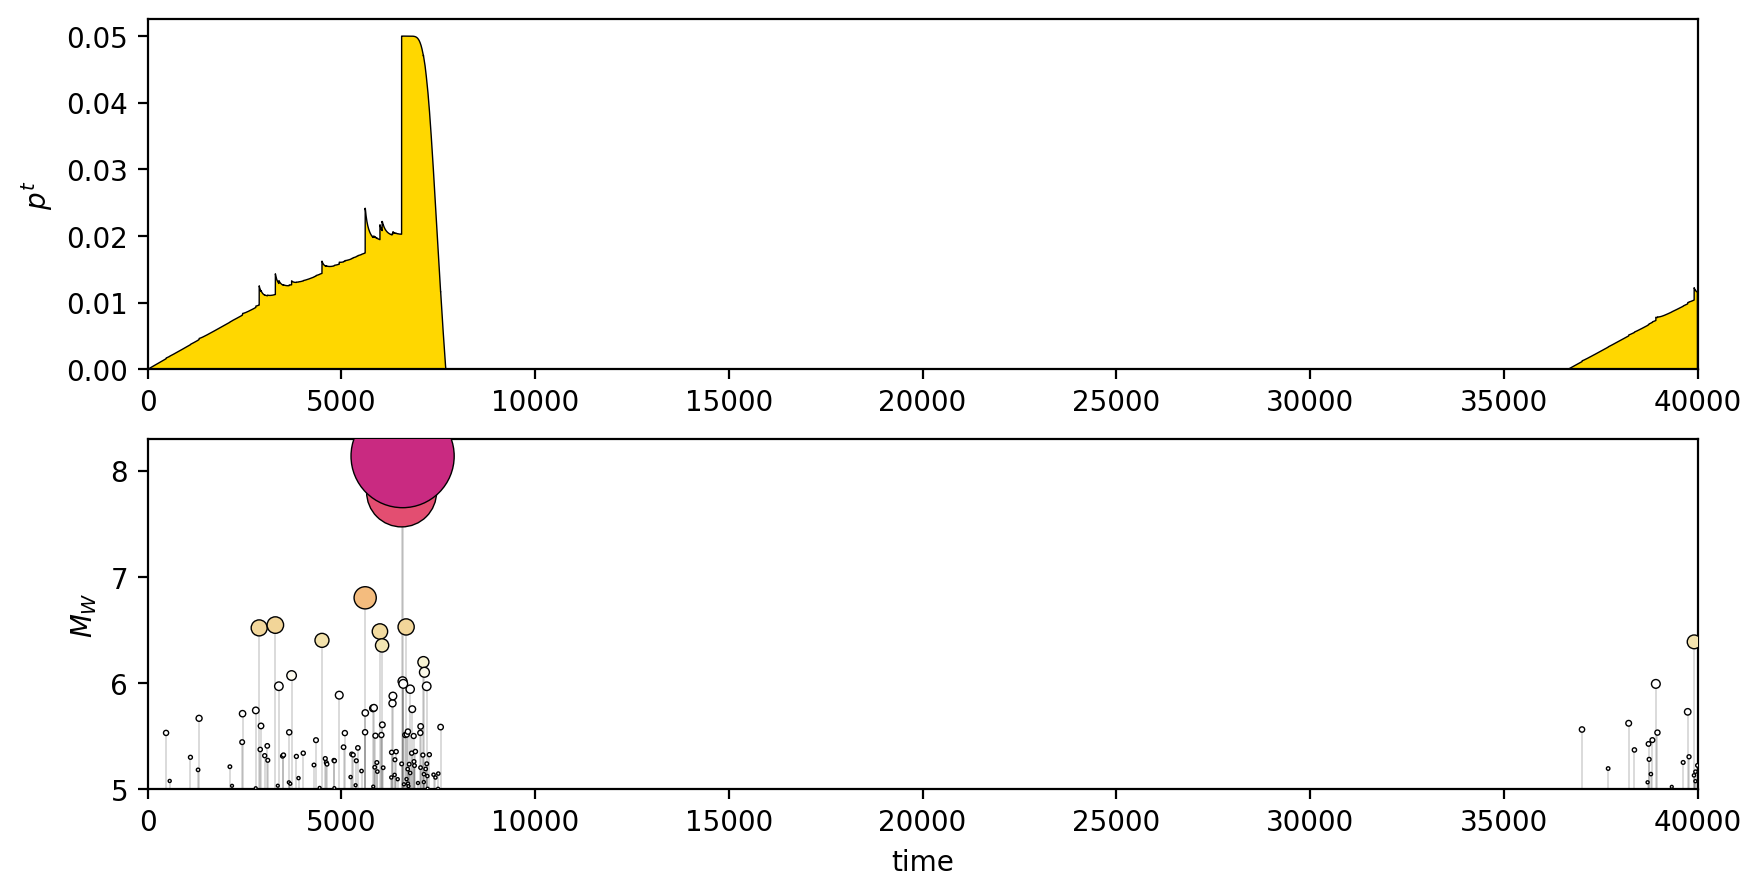

In [7]:
def plot_probability_and_events_time_series(
    time_series,
    start_idx,
    end_idx,
):
    event_idx = np.where(time_series.event_trigger_flag == 1)[0]
    figsize = (10, 5)
    plt.figure(figsize=figsize)

    # Plot probability time series
    plt.subplot(2, 1, 1)
    plt.plot(
        time_series.time[start_idx:end_idx],
        time_series.probability_weight[start_idx:end_idx],
        "-k",
        linewidth=0.5,
    )
    plt.plot(
        [time_series.time[start_idx], time_series.time[end_idx - 1]],
        [0, 0],
        "-k",
        linewidth=0.5,
    )
    plt.fill_between(
        time_series.time[start_idx:end_idx],
        time_series.probability_weight[start_idx:end_idx],
        np.zeros_like(time_series.time[start_idx:end_idx]),
        time_series.probability_weight[start_idx:end_idx] > 0,
        color="gold",
        alpha=1.0,
        edgecolor=None,
    )

    plt.fill_between(
        time_series.time[start_idx:end_idx],
        time_series.probability_weight[start_idx:end_idx],
        np.zeros_like(time_series.time[start_idx:end_idx]),
        time_series.probability_weight[start_idx:end_idx] < 0,
        color="dodgerblue",
        alpha=1.0,
        edgecolor=None,
    )
    plt.xlim([start_idx, end_idx])
    plt.gca().set_ylim(bottom=0.0)
    plt.ylabel("$p^t$")

    # Plot earthquake magnitude stem plot
    plt.subplot(2, 1, 2)
    for i in range(event_idx.size):
        plt.plot(
            [
                time_series.time[event_idx[i]],
                time_series.time[event_idx[i]],
            ],
            [
                params.minimum_event_moment_magnitude,
                time_series.event_magnitude[event_idx[i]],
            ],
            "-",
            linewidth=0.1,
            zorder=10,
            color="k",
        )

    cmap = cc.cm.CET_L17
    magnitude_plot_size = 1e-5 * 10 ** time_series.event_magnitude[event_idx]
    plt.scatter(
        time_series.time[event_idx],
        time_series.event_magnitude[event_idx],
        s=magnitude_plot_size,
        c=time_series.event_magnitude[event_idx],
        zorder=20,
        alpha=1.0,
        edgecolors="k",
        linewidths=0.5,
        cmap=cmap,
        vmin=6.0,
        vmax=9.0,
    )

    plt.xlabel("time")
    plt.ylabel("$M_W$")
    plt.xlim([start_idx, end_idx])
    plt.gca().set_ylim(bottom=params.minimum_event_moment_magnitude)
    plt.savefig(run_name + "_probability_magnitude" + ".pdf")
    plt.savefig(run_name + "_probability_magnitude" + ".png", dpi=500)
    plt.show()


start_idx = 0
end_idx = time_series.time.size
plot_probability_and_events_time_series(
    time_series,
    start_idx,
    end_idx,
)





In [8]:
# TODO: #25 Calculate mean time between earthquakes at different magnitudes
# TODO: #26 Add background random seismicity component

In [9]:
# np.roll example of rotating an array by rows
a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(np.roll(a, 1, 0))

[[7 8 9]
 [1 2 3]
 [4 5 6]]


In [10]:
# Inpolygon speed tests based on information from:
# https://stackoverflow.com/questions/36399381/whats-the-fastest-way-of-checking-if-a-point-is-inside-a-polygon-in-python

# Classic skies

# Can we do better?  Some references:
# https://plotly.com/python/v3/interpolation-and-extrapolation-in-2d/
# https://github.com/GlacioHack/xdem/pull/165
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html#scipy.interpolate.interp2d

# Nearest neighbor griddata
# import timeit
# fill_value = event.slip_all_elements
# fill_value = np.random.rand(event.slip_all_elements.size)
# x_vec = np.linspace(params.min_longitude, params.max_longitude, params.n_grid_longitude)
# y_vec = np.linspace(params.min_latitude, params.max_latitude, params.n_grid_latitude)
# x_mat, y_mat = np.meshgrid(x_vec, y_vec)
# centroids_lon = meshes[0].centroids[:, 0]
# centroids_lat = meshes[0].centroids[:, 1]
# centroids_val = fill_value

# from scipy.interpolate import griddata

# start_time = timeit.default_timer()
# fill_value_mat = griddata(
#     (centroids_lon, centroids_lat), fill_value, (x_mat, y_mat), method="cubic"
# )
# print(f"interp2d elapsed time: {timeit.default_timer() - start_time}")


# # Select only values inside of mesh polygon
# start_time = timeit.default_timer()
# inpolygon_vals = skies.inpolygon(
#     x_mat, y_mat, meshes[0].x_perimeter, meshes[0].y_perimeter
# )
# inpolygon_vals = np.reshape(
#     inpolygon_vals, (params.n_grid_longitude, params.n_grid_latitude)
# )
# fill_value_mat[~inpolygon_vals] = np.nan
# print(f"inpolygon elapsed time: {timeit.default_timer() - start_time}")
# print()


# # Plot
# cmap = cc.cm.CET_L19
# levels = np.linspace(
#     params.min_contour_value, np.nanmax(fill_value_mat), params.n_contour_levels
# )
# plt.contourf(x_mat, y_mat, fill_value_mat, cmap=cmap, levels=levels, extend="both")
# # cb = plt.colorbar(cax=plt.gca().inset_axes((0.03, 0.60, 0.02, 0.35)), label="slip (m)")
# plt.contour(
#     x_mat,
#     y_mat,
#     fill_value_mat,
#     colors="k",
#     linestyles="solid",
#     linewidths=0.25,
#     levels=levels,
# )
# plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, "-k", linewidth=1.0)
# plt.gca().set_aspect("equal", adjustable="box")
# plt.gca().set_facecolor("gainsboro")
# plt.title(f"$M_W$ = {event.moment_magnitude:0.3}")
# plt.show()
